## Declaração de bibliotecas e demais configurações

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import csv
import matplotlib.gridspec as gridspec

from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier

#from matplotlib import rcParams
#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

np.random.seed(12345) #Deseja fixar a semente geradora de números aleatórios?

## Funções relacionadas ao método ou auxiliares

In [6]:
#Função de leitura dos dados------------------------------------
def read_class_data(path):
    with open(path, newline='') as f:
        reader = csv.reader(f,delimiter=',')
        for row in reader:
            try:
                data = np.vstack( (data , np.asarray(row).astype(np.float) ) )
            except:
                data = np.asarray(row).astype(np.float)
    f.close()
    y = data[:,0]
    x = data[:,1:]
    return y,x

## Leitura e normalização dos dados 
* Os dados simulados anteriormente ($\texttt{dados.txt}$) já estão no formato esperado

In [7]:
#Dados de treinamento
path = 'dados.txt'

#Leitura dos dados
y,x_ = read_class_data(path)

escalonador = preprocessing.MinMaxScaler()
x = escalonador.fit_transform(x_)

## Separação aleatória dos dados para treinamento e avaliação
* Já discutido anteriormente (na aula sobre classificadores não lineares)
* É definida uma porcentagem destinada para avaliação, e restante é usado para treino
* Tal divisão é aleatoria

In [8]:
#Gerar conjunto de treino e avaliação a partir de uma única fonte
percentAvalia = 0.33

#A ordenação dos valores aleatórios segundo seu índice/argumento
#O resultado é uma nova ordem aleatória (mais conveniente para este caso)
posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))

#Subconjunto de avaliação
yI = y[ posAleatorias[0: np.int64(np.ceil(y.shape[0]*percentAvalia)) ] ]
xI = x[ posAleatorias[0: np.int64(np.ceil(y.shape[0]*percentAvalia)) ] , :]

#Subconjunto de treino
yD = y[ posAleatorias[np.int64(np.floor(y.shape[0]*percentAvalia)):-1] ]
xD = x[ posAleatorias[np.int64(np.floor(y.shape[0]*percentAvalia)):-1] , :]

## Visualizacão dos dados de treino/avaliação

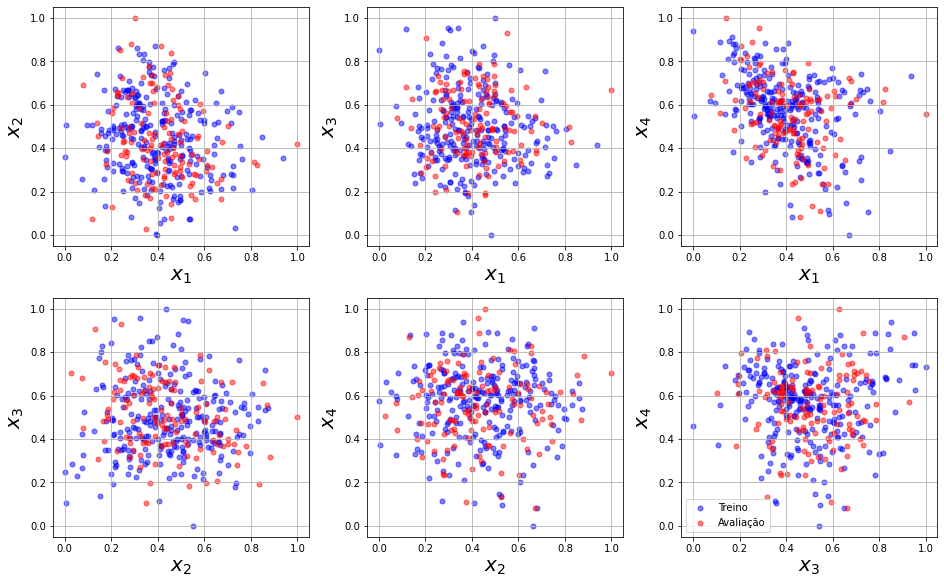

In [9]:
FS = (13,8) #Tamanho da figura a ser gerada
fig = plt.figure(constrained_layout=True,figsize=FS)
spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

#Variável de suporte (combinações de atributos)
contaComb = 0
combAtribs = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
nomeEixos = ['$x_1$','$x_2$','$x_3$','$x_4$']

for i in range(0,2):
    for j in range(0,3):
        ax = fig.add_subplot(spec[i, j])
        ax.scatter(xD[:, combAtribs[contaComb][0]], xD[:, combAtribs[contaComb][1]], marker='o', c='blue', s=25, alpha=0.5, label='Treino')
        ax.scatter(xI[:, combAtribs[contaComb][0]], xI[:, combAtribs[contaComb][1]], marker='o', c='red', s=25,alpha=0.5, label='Avaliação')
        ax.set_xlabel(nomeEixos[combAtribs[contaComb][0]], fontsize=20)
        ax.set_ylabel(nomeEixos[combAtribs[contaComb][1]], fontsize=20)
        ax.grid(True)
        contaComb += 1

ax.legend(fontsize=10)

## Classificação dos dados
* São apresentados na sequência as diferentes abordagens de combinação discutidas
* Não é dada atenção devisa as parametrizações/composições

## Classificações de referência ("baselines")
* SVM com Kernel {Linear, RBF} (C=100, gamma=0.5, OVR)
* CART com min_samples_split= {2,10}

In [10]:
G = []
G.append( DecisionTreeClassifier(min_samples_split=2,criterion='entropy',min_impurity_decrease=10**(-5),random_state=1) )
G.append( DecisionTreeClassifier(min_samples_split=10,criterion='entropy',min_impurity_decrease=10**(-5),random_state=1) )
G.append( SVC(kernel='linear', C=100, probability=True) )
G.append( SVC(kernel='rbf', C=100, gamma=0.5, probability=True) )

nomeModelo = ['CART+Psi2 ','CART+Psi10','SVM+Linear','SVM+RBF   ']
for i in range(0,4):
    G[i].fit(xD,yD)
    yEst = G[i].predict(xI)
    avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
    print(nomeModelo[i]+' --- ', avalia)

CART+Psi2  ---  0.6666666666666666
CART+Psi10 ---  0.6590909090909091
SVM+Linear ---  0.7651515151515151
SVM+RBF    ---  0.7727272727272727


### Votação por Maioria

In [12]:
g1 = DecisionTreeClassifier(min_samples_split=2,criterion='entropy',min_impurity_decrease=10**(-5),random_state=1)
g2 = DecisionTreeClassifier(min_samples_split=10,criterion='entropy',min_impurity_decrease=10**(-5),random_state=1)
g3 = SVC(kernel='linear', C=100, probability=True)
g4 = SVC(kernel='rbf', C=100, gamma=0.5, probability=True)
modelos = [('dt1', g1),('dt2', g2),('svc1', g3),('svc2', g4)]

#Instanciação
hardVote = VotingClassifier(estimators=modelos,voting='hard')
#Treinamento
hardVote.fit(xD, yD)
#Predição
yEst_hardVote = hardVote.predict(xI)

#Concordâncias...
avalia = np.count_nonzero(yEst_hardVote == yI) / yI.shape[0]
print('Acurácia: ', avalia)

Acurácia:  0.7575757575757576


### Regras derivadas de Bayes (Regra da Soma)

In [13]:
g1 = DecisionTreeClassifier(max_depth=4)
g2 = DecisionTreeClassifier(max_depth=8)
g3 = SVC(kernel='linear', C=100, probability=True)
g4 = SVC(kernel='rbf', C=100, gamma=0.5, probability=True)
modelos = [('dt1', g1),('dt2', g2),('svc1', g3),('svc2', g4)]

#Instanciação
softVote = VotingClassifier(estimators=modelos,voting='soft', weights=[1, 1, 1, 1])
#Treinamento
softVote.fit(xD, yD)
#Predição
yEst_softVote = softVote.predict(xI)

#Concordâncias...
avalia = np.count_nonzero(yEst_softVote == yI) / yI.shape[0]
print('Acurácia: ', avalia)

Acurácia:  0.7045454545454546


### Bagging

In [14]:
#Instanciação
modelo = SVC(C=100, kernel='rbf',gamma=0.5)
bag = BaggingClassifier(base_estimator= modelo, n_estimators=20, random_state=0)

#Treinamento
bag.fit(xD,yD)
#Predição efetuada por cada uma das redes
yEst_bag = bag.predict(xI)

#Concordâncias...
avalia = np.count_nonzero(yEst_bag == yI) / yI.shape[0]
print('Acurácia: ', avalia)

Acurácia:  0.7727272727272727


### AdaBoost/SAMME

In [15]:
#Instanciação
modelo = SVC(C=100, kernel='rbf',gamma=0.5,probability=True)
combClass = AdaBoostClassifier(modelo,n_estimators=10)

#Treinamento
combClass.fit(xD, yD)
#Predição
yEst = combClass.predict(xI)

#Concordâncias...
avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
print('Acurácia: ', avalia)

Acurácia:  0.7045454545454546


### Random Forest

In [23]:
#Instanciação
combClass = RandomForestClassifier(n_estimators=2500, criterion='entropy', 
                                   min_samples_split=10, min_impurity_decrease=10**(-7),random_state=1)
#Treinamento
combClass.fit(xD, yD)
#Predição efetuada por cada uma das redes
yEst = combClass.predict(xI)

#Concordâncias...
avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
print('Acurácia: ', avalia)

Acurácia:  0.7121212121212122


### Stacking
* Esta implementado a partir da versão 0.22 do Scikit-Learn

In [25]:
##Definição dos modelos
g1 = DecisionTreeClassifier(max_depth=4)
g2 = DecisionTreeClassifier(max_depth=8)
g3 = SVC(kernel='linear', C=100, probability=True)
g4 = SVC(kernel='rbf', C=100, gamma=0.5, probability=True)
estimadores = [('dt1', g1),('dt2', g2),('svc1', g3),('svc2', g4)]

##Instanciação
combClass = StackingClassifier(estimators=estimadores, final_estimator=SVC(kernel='rbf', C=100, gamma=0.5) )
    
##Treinamento
combClass.fit(xD, yD)
##Predição
yEst = combClass.predict(xI)

##Concordâncias...
avalia = np.count_nonzero(yEst == yI) / yI.shape[0]
print('Acurácia: ', avalia)

Acurácia:  0.7196969696969697


### Comparação segundo o número de modelos na combinação
* Usar diferentes conjuntos para treinar e avaliar
* Considerar a média das avaliações (mais robusta) como valor de referência/comparação

In [26]:
#Modelos
RF = RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=10, min_impurity_decrease=10**(-5), random_state=0)
AB_SVM = AdaBoostClassifier(SVC(C=100, kernel='rbf',gamma=0.5,probability=True), n_estimators=100, random_state=0)
AB_CART = AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10,criterion='entropy',min_impurity_decrease=10**(-5),random_state=1), n_estimators=100, random_state=0)
bixao = SVC(C=100, kernel='rbf',gamma=0.5,probability=True)

#Configuração do experimento...
#n_estimadores = [2,4,8,16,32,64,126,256,512]
n_estimadores = [2,4,8,16,32,64,128,256]
acuraciasAdaBoost_SVM = []
acuraciasAdaBoost_CART = []
acuraciasRandomForest = []
acuraciasSVM = []
n_avalia = 5
percentAvalia = 0.33
N = y.shape[0]

for estims in n_estimadores:                    #Rodada de avaliação com uma quantidade de modelos

    RF.set_params(n_estimators=estims)          #Definindo o número de modelos
    AB_SVM.set_params(n_estimators=estims)      #Inden.
    AB_CART.set_params(n_estimators=estims)     #Inden.
    accRF, accAB_SVM, accAB_CART, accSVM = 0, 0, 0, 0      #Zera o contador de acurácias dos métodos AB e RF
    for k in range(0,n_avalia):                 #Testes com diferentes conjuntos de treino
        
        #Sortetio e divisão...
        posAleatorias = np.argsort(np.random.uniform(0,1, y.shape[0] ))
        #Subconjunto de avaliação
        yI = y[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] ]
        xI = x[ posAleatorias[0: np.int64(np.ceil(N*percentAvalia)) ] , :]
        #Subconjunto de treino
        yD = y[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] ]
        xD = x[ posAleatorias[np.int64(np.floor(N*percentAvalia)):-1] , :]
        
        #Treino e predição...
        RF.fit(xD,yD); yPred_RF = RF.predict(xI)
        AB_SVM.fit(xD,yD); yPred_AB_SVM = AB_SVM.predict(xI)
        AB_CART.fit(xD,yD); yPred_AB_CART = AB_CART.predict(xI)
        bixao.fit(xD,yD); yPred_SVM = bixao.predict(xI)
        
        #Avaliação
        accRF += np.count_nonzero(yPred_RF == yI) / yI.shape[0]
        accAB_SVM += np.count_nonzero(yPred_AB_SVM == yI) / yI.shape[0]
        accAB_CART += np.count_nonzero(yPred_AB_CART == yI) / yI.shape[0]
        accSVM += np.count_nonzero(yPred_SVM == yI) / yI.shape[0]
    
    #Contabilização/acumulo das acurácias
    acuraciasRandomForest.append(accRF/n_avalia)
    acuraciasAdaBoost_SVM.append(accAB_SVM/n_avalia)
    acuraciasAdaBoost_CART.append(accAB_CART/n_avalia)
    acuraciasSVM.append(accSVM/n_avalia)

### Construção do gráfico

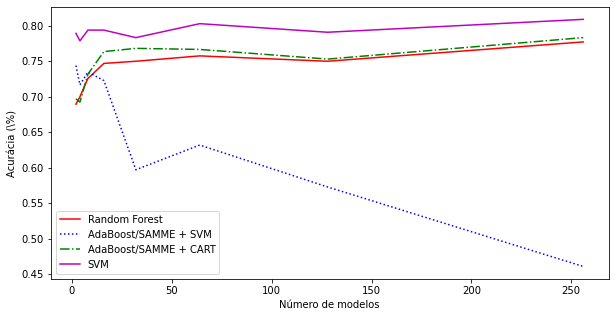

In [27]:
#Construção do gráfico de desempenho
fig = plt.figure(figsize=(10,5))
plt.plot(n_estimadores , acuraciasRandomForest, 'r-', label='Random Forest')
plt.plot(n_estimadores , acuraciasAdaBoost_SVM, 'b:', label='AdaBoost/SAMME + SVM')
plt.plot(n_estimadores , acuraciasAdaBoost_CART, 'g-.', label='AdaBoost/SAMME + CART')
plt.plot(n_estimadores , acuraciasSVM, 'm-', label='SVM')
plt.xlabel("Número de modelos")
plt.ylabel("Acurácia (\%)")
plt.legend()
plt.show()